# Medical Image Classification with PyHealth

Welcome to the PyHealth tutorial on image classification and saliency mapping. In this notebook, we will explore how to use PyHealth to analyze chest X-ray images, classify them into various chest diseases, and visualize the model's decision-making process using gradient saliency maps.

## Environment Setup

First, let's install the required packages and set up our environment.

In [1]:
!pip install mne pandarallel rdkit transformers torch torchvision openpyxl polars

In [ ]:
!rm -rf PyHealth
!git clone https://github.com/sunlabuiuc/PyHealth.git

Cloning into 'PyHealth'...
remote: Enumerating objects: 7946, done.
remote: Counting objects: 100% (1459/1459), done.
remote: Compressing objects: 100% (421/421), done.
remote: Total 7946 (delta 1306), reused 1042 (delta 1038), pack-reused 6487 (from 2)
Receiving objects: 100% (7946/7946), 118.94 MiB | 33.66 MiB/s, done.
Resolving deltas: 100% (5055/5055), done.


In [ ]:
import sys

sys.path.append("./PyHealth")

## Download Data

Next, we will download the dataset containing COVID-19 data. This dataset includes chest X-ray images of normal cases, lung opacity, viral pneumonia, and COVID-19 patients. You can find more information about the dataset [here](https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database).

Download and extract the dataset:

In [4]:
!wget -N https://storage.googleapis.com/pyhealth/covid19_cxr_data/archive.zip

--2025-11-15 18:18:00--  https://storage.googleapis.com/pyhealth/covid19_cxr_data/archive.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.191.251, 142.251.32.27, 172.217.1.123, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.191.251|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘archive.zip’ not modified on server. Omitting download.



In [5]:
!unzip -q -o archive.zip

In [6]:
!ls -1 COVID-19_Radiography_Dataset

COVID
COVID.metadata.xlsx
Lung_Opacity
Lung_Opacity.metadata.xlsx
Normal
Normal.metadata.xlsx
README.md.txt
'Viral Pneumonia'
'Viral Pneumonia.metadata.xlsx'
covid19_cxr-metadata-pyhealth.csv


Next, we will proceed with the chest X-ray classification task using PyHealth, following a five-stage pipeline.

## Step 1. Load Data in PyHealth

The initial step involves loading the data into PyHealth's internal structure. This process is straightforward: import the appropriate dataset class from PyHealth and specify the root directory where the raw dataset is stored. PyHealth will handle the dataset processing automatically.

In [7]:
from pyhealth.datasets import COVID19CXRDataset

root = "COVID-19_Radiography_Dataset"
base_dataset = COVID19CXRDataset(root)

No config path provided, using default config
Initializing covid19_cxr dataset from COVID-19_Radiography_Dataset (dev mode: False)
Scanning table: covid19_cxr from /opt/workspace/PyHealth-fitzpa15/examples/COVID-19_Radiography_Dataset/covid19_cxr-metadata-pyhealth.csv


Once the data is loaded, we can perform simple queries on the dataset:

In [8]:
base_dataset.stats()

Collected dataframe with shape: (21165, 6)
Dataset: covid19_cxr
Dev mode: False
Number of patients: 21165
Number of events: 21165


In [9]:
base_dataset.get_patient("0").get_events()

Found 21165 unique patient IDs


[Event(event_type='covid19_cxr', timestamp=datetime.datetime(2025, 11, 15, 18, 18, 14, 278202), attr_dict={'path': 'COVID-19_Radiography_Dataset/COVID/images/COVID-1.png', 'url': 'https://sirm.org/category/senza-categoria/covid-19/', 'label': 'COVID'})]

## Step 2. Define the Task

The next step is to define the machine learning task. This step instructs the package to generate a list of samples with the desired features and labels based on the data for each individual patient. Please note that in this dataset, patient identification information is not available. Therefore, we will assume that each chest X-ray belongs to a unique patient.

For this dataset, PyHealth offers a default task specifically for chest X-ray classification. This task takes the image as input and aims to predict the chest diseases associated with it.

In [10]:
base_dataset.default_task

In [11]:
sample_dataset = base_dataset.set_task()

Setting task COVID19CXRClassification for covid19_cxr base dataset...
Generating samples with 1 worker(s)...


Generating samples for COVID19CXRClassification with 1 worker: 100%|██████████| 21165/21165 [00:17<00:00, 1235.15it/s]

Label disease vocab: {'COVID': 0, 'Lung Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}



Processing samples: 100%|██████████| 21165/21165 [00:34<00:00, 615.92it/s]

Generated 21165 samples for task COVID19CXRClassification


Here is an example of a single sample, represented as a dictionary. The dictionary contains keys for feature names, label names, and other metadata associated with the sample.

In [12]:
sample_dataset[0]

{'image': tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0667, 0.0667, 0.0667],
          [0.0000, 0.0000, 0.0000,  ..., 0.0706, 0.0745, 0.0745],
          [0.0000, 0.0000, 0.0000,  ..., 0.0667, 0.0706, 0.0706],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]),
 'disease': tensor(2)}

We can also check the input and output schemas, which specify the data types of the features and labels.

In [13]:
sample_dataset.input_schema

{'image': 'image'}

In [14]:
sample_dataset.output_schema

{'disease': 'multiclass'}

Below, we plot the number of samples per classes, and visualize some samples.

In [15]:
label2id = sample_dataset.output_processors["disease"].label_vocab
id2label = {v: k for k, v in label2id.items()}

defaultdict(<class 'int'>, {'Normal': 10192, 'Lung Opacity': 6012, 'COVID': 3616, 'Viral Pneumonia': 1345})


<BarContainer object of 4 artists>

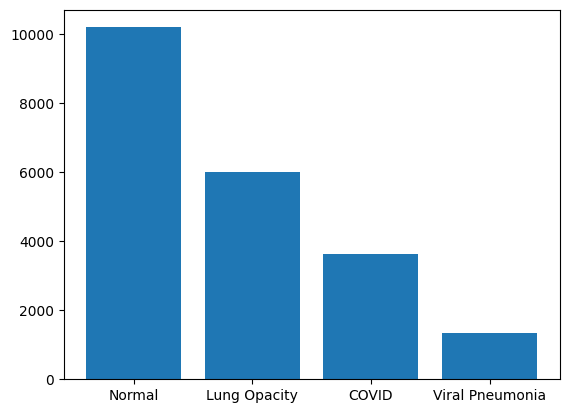

In [16]:
from collections import defaultdict
import matplotlib.pyplot as plt

label_counts = defaultdict(int)
for sample in sample_dataset.samples:
    label_counts[id2label[sample["disease"].item()]] += 1
print(label_counts)
plt.bar(label_counts.keys(), label_counts.values())

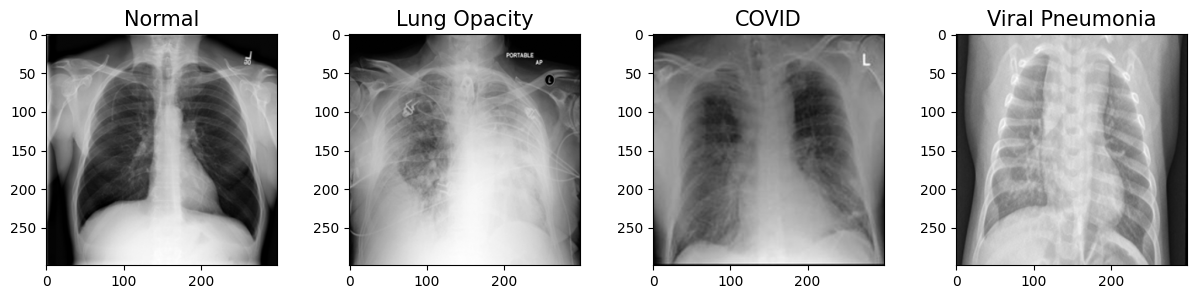

In [17]:
import random

label_to_idxs = defaultdict(list)
for idx, sample in enumerate(sample_dataset.samples):
    label_to_idxs[sample["disease"].item()].append(idx)

fig, axs = plt.subplots(1, 4, figsize=(15, 3))
for ax, label in zip(axs, label_to_idxs.keys()):
    ax.set_title(id2label[label], fontsize=15)
    idx = random.choice(label_to_idxs[label])
    sample = sample_dataset[idx]
    image = sample["image"][0]
    ax.imshow(image, cmap="gray")

Finally, we will split the entire dataset into training, validation, and test sets using the ratios of 70%, 10%, and 20%, respectively. We will then obtain the corresponding data loaders for each set.

In [18]:
from pyhealth.datasets import split_by_sample

train_dataset, val_dataset, test_dataset = split_by_sample(
    dataset=sample_dataset,
    ratios=[0.7, 0.1, 0.2]
)

In [19]:
from pyhealth.datasets import get_dataloader

train_dataloader = get_dataloader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = get_dataloader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = get_dataloader(test_dataset, batch_size=32, shuffle=False)

## Step 3. Define the Model

Next, we will define the deep learning model we want to use for our task. PyHealth supports all major vision models available in the Torchvision package. You can load any of these models using the model_name argument.

In [20]:
from pyhealth.models import TorchvisionModel

resnet = TorchvisionModel(
    dataset=sample_dataset,
    model_name="resnet18",
    model_config={"weights": "DEFAULT"}
)

resnet

/opt/workspace/PyHealth-fitzpa15/pyhealth/sampler/sage_sampler.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/opt/workspace/PyHealth-fitzpa15/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TorchvisionModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [21]:
from pyhealth.models import TorchvisionModel

vit = TorchvisionModel(
    dataset=sample_dataset,
    model_name="vit_b_16",
    model_config={"weights": "DEFAULT"}
)

vit

TorchvisionModel(
  (model): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1)

## Step 4. Training

In this step, we will train the model using PyHealth's Trainer class, which simplifies the training process and provides standard functionalities.

Let us first train the ResNet model.

In [22]:
from pyhealth.trainer import Trainer

resnet_trainer = Trainer(model=resnet)

TorchvisionModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

Before we begin training, let's first evaluate the initial performance of the model.

In [23]:
print(resnet_trainer.evaluate(test_dataloader))

Evaluation: 100%|██████████| 133/133 [00:04<00:00, 29.72it/s]

{'accuracy': 0.28632175761871015, 'f1_macro': 0.11129476584022038, 'f1_micro': 0.28632175761871015, 'loss': 1.4082512721083218}


Now, let's start the training process. Due to computational constraints, we will train the model for only one epoch.

In [24]:
resnet_trainer.train(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=1,
    monitor="accuracy"
)

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x743872204440>
Monitor: accuracy
Monitor criterion: max
Epochs: 1
Patience: None



Epoch 0 / 1: 100%|██████████| 463/463 [00:47<00:00,  9.72it/s]

--- Train epoch-0, step-463 ---
loss: 0.3361



Evaluation: 100%|██████████| 67/67 [00:01<00:00, 33.77it/s]

--- Eval epoch-0, step-463 ---
accuracy: 0.7345
f1_macro: 0.7418
f1_micro: 0.7345
loss: 0.7607
New best accuracy score (0.7345) at epoch-0, step-463


Loaded best model


After training the model, we can compare its performance before and after. We should expect to see an increase in the accuracy score as the model learns from the training data.

## Step 5. Evaluation

Lastly, we can evaluate the ResNet model on the test set. This can be done using PyHealth's `Trainer.evaluate()` function.

In [25]:
print(resnet_trainer.evaluate(test_dataloader))

Evaluation: 100%|██████████| 133/133 [00:04<00:00, 32.66it/s]

{'accuracy': 0.7396645405150012, 'f1_macro': 0.737870641291378, 'f1_micro': 0.7396645405150012, 'loss': 0.7614034954318427}


Additionally, you can perform inference using the `Trainer.inference()` function.

In [26]:
y_true, y_prob, loss = resnet_trainer.inference(test_dataloader)
y_pred = y_prob.argmax(axis=1)

Evaluation: 100%|██████████| 133/133 [00:04<00:00, 31.10it/s]


Below we show a confusion matrix of the trained ResNet model.

Text(50.722222222222214, 0.5, 'True')

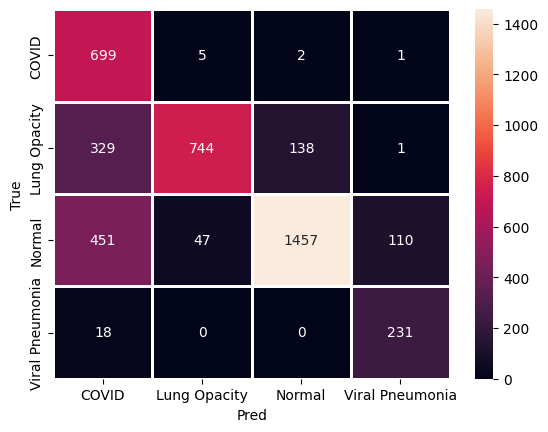

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_true, y_pred)
ax = sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='g')
ax.set_xticklabels([id2label[i] for i in range(4)])
ax.set_yticklabels([id2label[i] for i in range(4)])
ax.set_xlabel("Pred")
ax.set_ylabel("True")

# 6 Gradient Saliency Mapping
For a bonus let's look at some simple gradient saliency maps applied to our sample dataset.

In [28]:
def add_requires_grad(in_dataset):
  for sample in in_dataset:
    sample['image'].requires_grad_()

In [ ]:
from pyhealth.interpret.methods.basic_gradient import BasicGradientSaliencyMaps
import torch

# Create a batch with only COVID samples
covid_label = label2id['COVID']
covid_samples = [sample for sample in sample_dataset.samples if sample['disease'].item() == covid_label]

# Take the first 32 COVID samples and create a batch
batch_size = min(32, len(covid_samples))
covid_batch = {
    'image': torch.stack([covid_samples[i]['image'] for i in range(batch_size)]),
    'disease': torch.stack([covid_samples[i]['disease'] for i in range(batch_size)])
}

print(f"Created COVID batch with {batch_size} samples")

# Initialize saliency maps with batch input only
saliency_maps = BasicGradientSaliencyMaps(
    resnet,
    input_batch=covid_batch
)

Created COVID batch with 32 samples


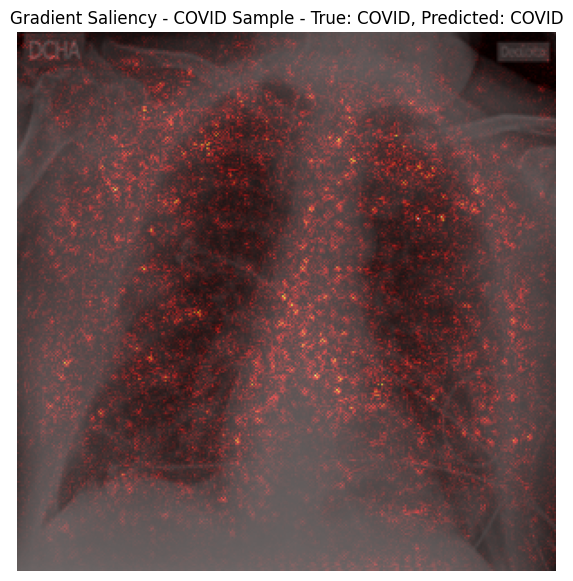

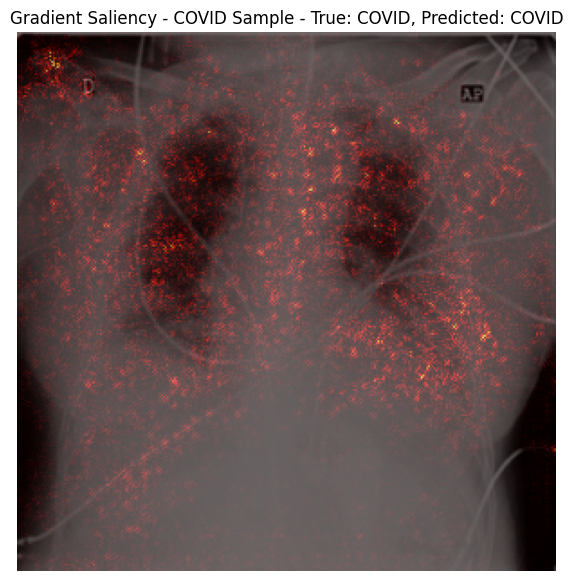

In [30]:
# Show saliency map for the first image in the batch
saliency_maps.visualize_saliency_map(plt, image_index=0, 
                                   title="Gradient Saliency - COVID Sample", 
                                   id2label=id2label, alpha=0.6)

# Show saliency map for another image in the batch
saliency_maps.visualize_saliency_map(plt, image_index=5, 
                                   title="Gradient Saliency - COVID Sample", 
                                   id2label=id2label, alpha=0.6)